<a href="https://colab.research.google.com/github/cydneel23/Dog-Neural-Networks/blob/main/dog_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook builds an end-to-end multi-class image classifier using TensorFlow 2.14 and TensorFlow Hub.

##1. Problem

Given an image of a dog, identify said dog's breed.

##2. Data
Data is from Kaggle's dog breed identification competition. https://www.kaggle.com/competitions/dog-breed-identification

##3. Evaluation

Evaluation is a file with prediction probabilities for each dog breed of each test image.

##4. Features
* Unstructured Data - pure images
* 120 breeds of dogs - 120 classes
* 10,000+ images in training set and test set, respectively

In [ ]:
#Unzip the data into Google Drove
#!unzip "drive/MyDrive/Tech Education/dog-breed-identification.zip" -d "drive/MyDrive/Tech Education"

Getting Workspace Ready

In [ ]:
#Import TensorFlow & TensorFlow Hub into Colab
import tensorflow as tf
import tensorflow_hub as hub
print("TF version:", tf.__version__)

#Check for GPU availability
print("Available" if tf.config.list_physical_devices("GPU") else "Not Available")

TF version: 2.13.0
Available


## Getting our data ready (turning into Tensors)


In [ ]:
#Access the data and check out the labels

import pandas as pd
labels_csv = pd.read_csv("drive/MyDrive/Tech Education/Dog Data/labels.csv")
print(labels_csv.describe())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126


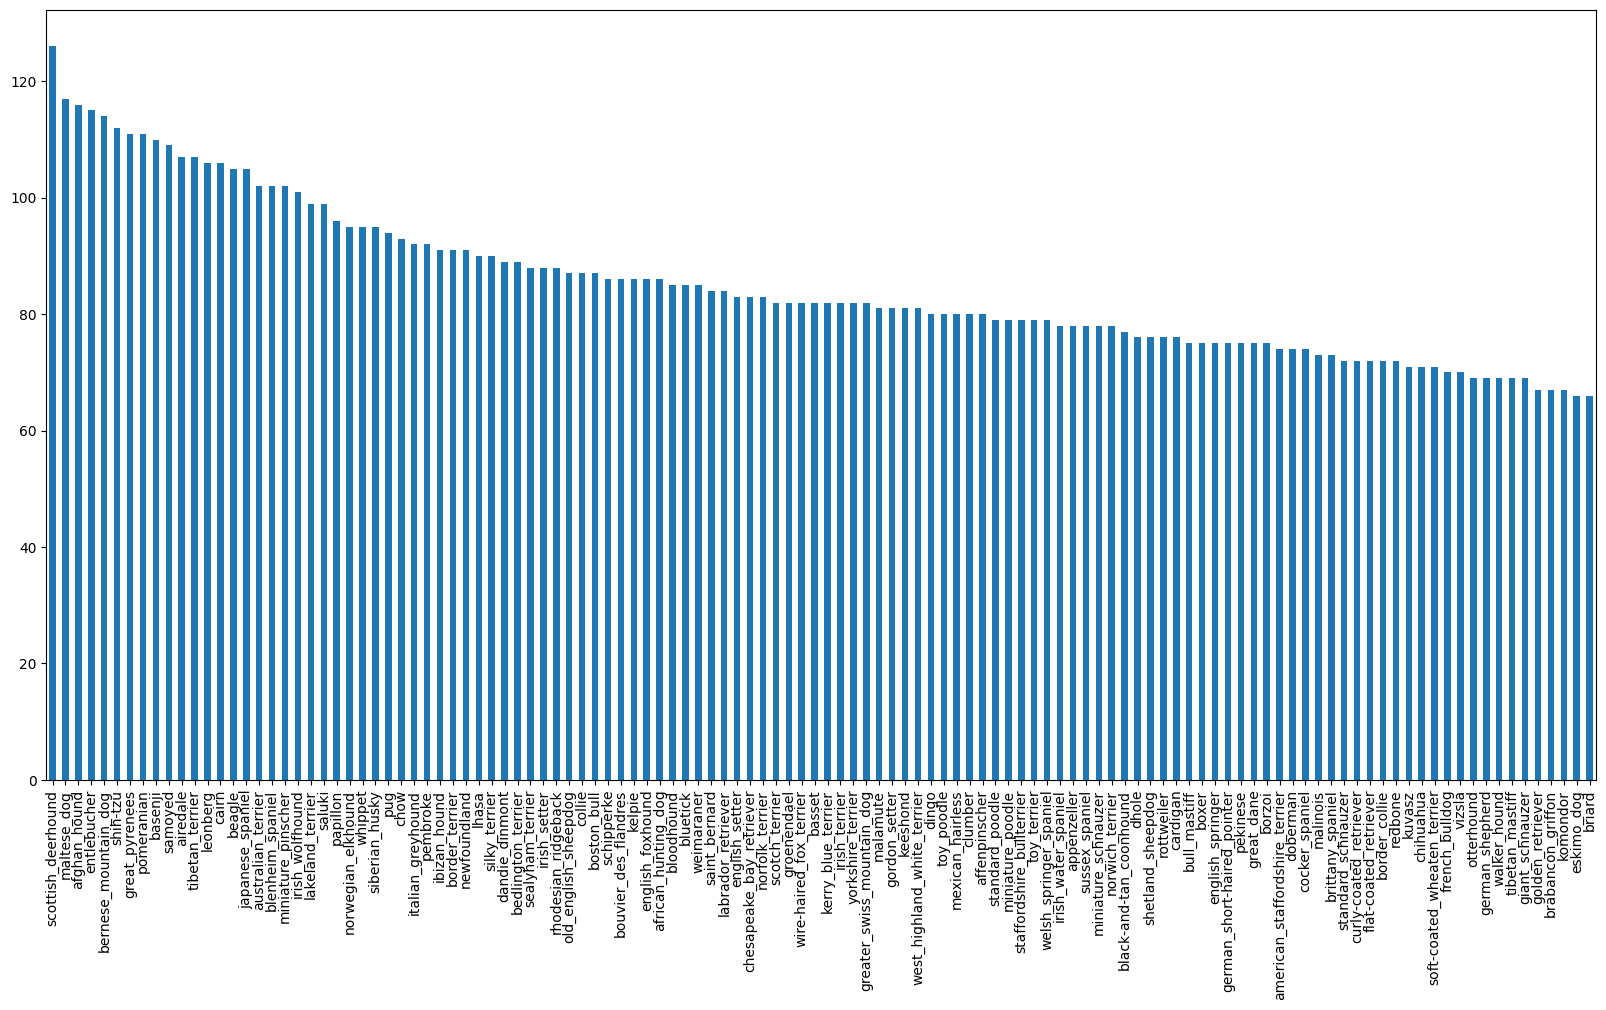

In [ ]:
# How many images of each breed?
labels_csv["breed"].value_counts().plot.bar(figsize=(20, 10));

In [ ]:
# What's the median number of images per class?
labels_csv["breed"].value_counts().median()

82.0

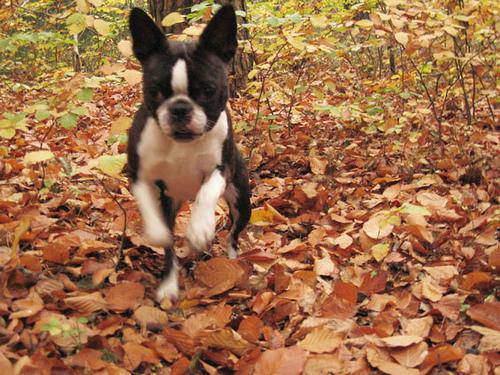

In [ ]:
# View an image
from IPython.display import Image
Image("drive/MyDrive/Tech Education/Dog Data/train/000bec180eb18c7604dcecc8fe0dba07.jpg")

### Getting images and their labels
Get a list of all image file pathnames by working with labels_csv

In [ ]:
# Create pathnames from image ID's
filenames = ["drive/MyDrive/Tech Education/Dog Data/train/" + fname + ".jpg" for fname in labels_csv["id"]]

# Check the first 10 filenames
filenames[:10]

['drive/MyDrive/Tech Education/Dog Data/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Tech Education/Dog Data/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Tech Education/Dog Data/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Tech Education/Dog Data/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Tech Education/Dog Data/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/Tech Education/Dog Data/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/Tech Education/Dog Data/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/Tech Education/Dog Data/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/Tech Education/Dog Data/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/Tech Education/Dog Data/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [ ]:
# Check if number of filenames match number of actual image files
import os
if len(os.listdir("drive/MyDrive/Tech Education/Dog Data/train/")) == len(filenames):
  print("Filenames match actual amount of files!")
else:
  print("Filenames do not match actual amount of files, check the target directory")

Filenames match actual amount of files!


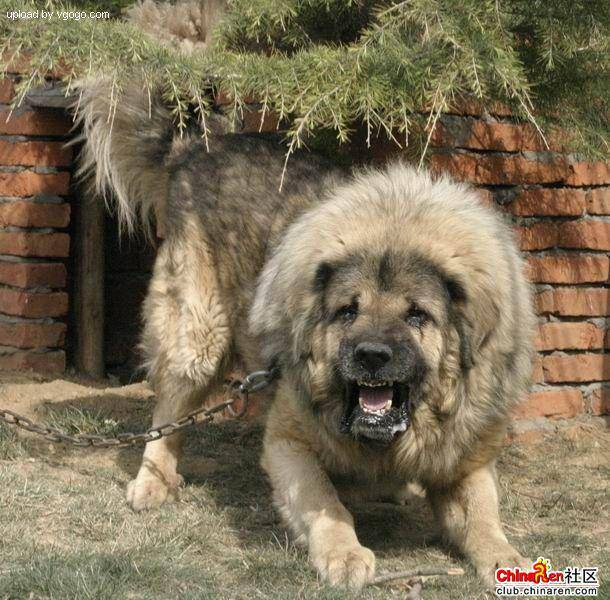

In [ ]:
# Another check on the data
# Check an image directly from a filepath
Image(filenames[9000])

Prepare the labels.
Images are ready, but labels need to be converted from string to numerical form.

In [ ]:
import numpy as np
labels = labels_csv["breed"].to_numpy() # convert labels column to NumPy array
labels[:10]

array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever',
       'bedlington_terrier', 'bedlington_terrier', 'borzoi', 'basenji',
       'scottish_deerhound'], dtype=object)

In [ ]:
# See if number of labels matches the number of filenames
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames!")
else:
  print("Number of labels does not match number of filenames, check data directories.")

Number of labels matches number of filenames!


In [ ]:
# Find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [ ]:
# Turn every label into a boolean array
boolean_labels = [label == np.array(unique_breeds) for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [ ]:
# Example: Turning a boolean array into integers
print(labels[0]) # original label
print(np.where(unique_breeds == labels[0])[0][0]) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occurs

boston_bull
19
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


## Creating a validation set as Kaggle doesn't provide one

In [ ]:
# Setup X & y variables
X = filenames
y = boolean_labels

Begin with experimenting with ~1000 images and increase as needed

In [ ]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}
NUM_IMAGES

1000

In [ ]:
# Import train_test_split from Scikit-Learn
from sklearn.model_selection import train_test_split

# Split them into training and validation using NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [ ]:
# Check out the training data (image file paths and labels)
X_train[:5], y_train[:2]

(['drive/MyDrive/Tech Education/Dog Data/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/MyDrive/Tech Education/Dog Data/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'drive/MyDrive/Tech Education/Dog Data/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'drive/MyDrive/Tech Education/Dog Data/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'drive/MyDrive/Tech Education/Dog Data/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, 

## Preprocessing images (turning images into Tensors)

To do this, a function will be created that:
1. Takes an image filename as input.
2. Uses TensorFlow to read the file and save it to a variable, image.
3. Turn our image (a jpeg file) into Tensors.
4. Resize the image to be of shape (224, 224).
5. Return the modified image.

In [ ]:
# Initial Exploration - Convert image to NumPy array
from matplotlib.pyplot import imread
image = imread(filenames[42]) # read in an image
image

array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]],

       [[ 56, 104,  66],
        [ 58, 106,  68],
        [ 64, 112,  74],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 74, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  11],
        [  8,  14,  14],
        ...,
        [120, 113,  67],
        [126, 118,  71],
        [122, 114,  67]],

       [[  0,   3,   7],
        [  2,   7,  10],
        [  3,   9,   7],
        ...,
        [105,  98,  54],
        [112, 104,  58],
        [111, 103,  57]],

       [[ 16,  18,  30],
        [ 16,  19,  24],
        [ 15,  20,  14],
        ...,
        [101,  92,  51],
        [ 97,  88,  47],
        [120, 111,  70]]

In [ ]:
#Initial Exploration -- see what an image looks like in Tensor form
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)>

In [ ]:
# Define image size
IMG_SIZE = 224

#Function for preprocessing images
def process_image(image_path):
  """
  Takes an image file path and turns it into a Tensor.
  """
  # Read in image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 colour channels (RGB)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour channel values from 0-225 values to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired size (224, 244)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
  return image

## Creating data batches
Turning data into TensorFlow BatchDataset
In order to do this, we need the data in the form of a tuple

In [ ]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label,
  processes the image and returns a tuple of (image, label).
  """
  image = process_image(image_path)
  return image, label

Now it's necessary to make a function to turn all of the data into batches

In [ ]:
# Define the batch size, 32 is a good default
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (x) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle it if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x))) # only filepaths
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # If the data if a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    # If the data is a training dataset, we shuffle it
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                              tf.constant(y))) # labels

    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(x))

    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [ ]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [ ]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing data batches
-- Visualization since batches can be a bit hard to understand at first

In [ ]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays 25 images from a data batch.
  """
  # Setup the figure
  plt.figure(figsize=(10, 10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn gird lines off
    plt.axis("off")

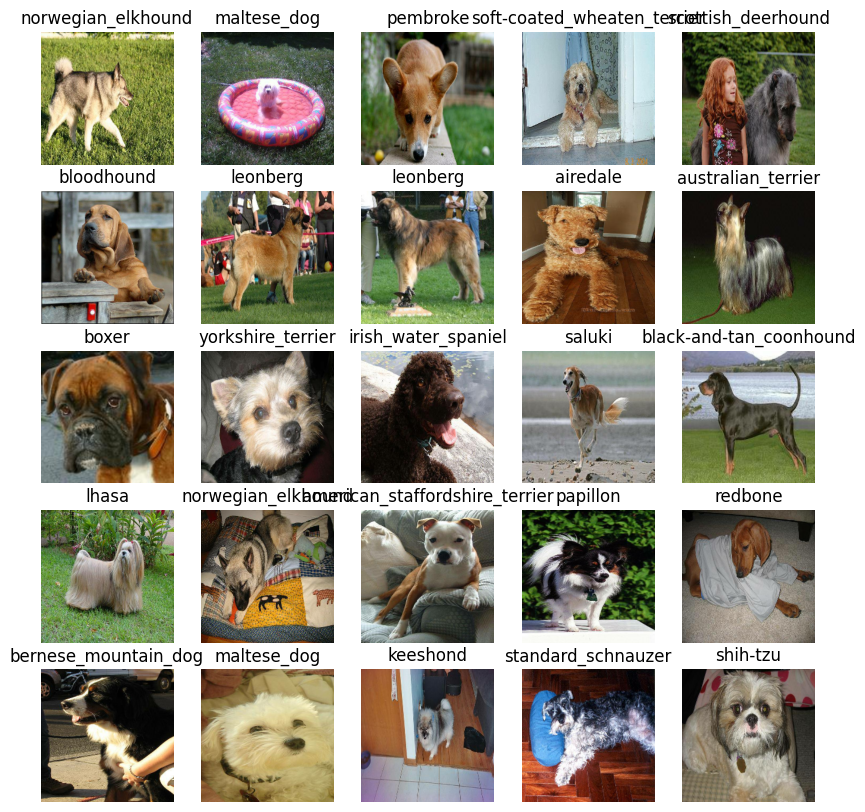

In [ ]:
# Visualize training images from the training data batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

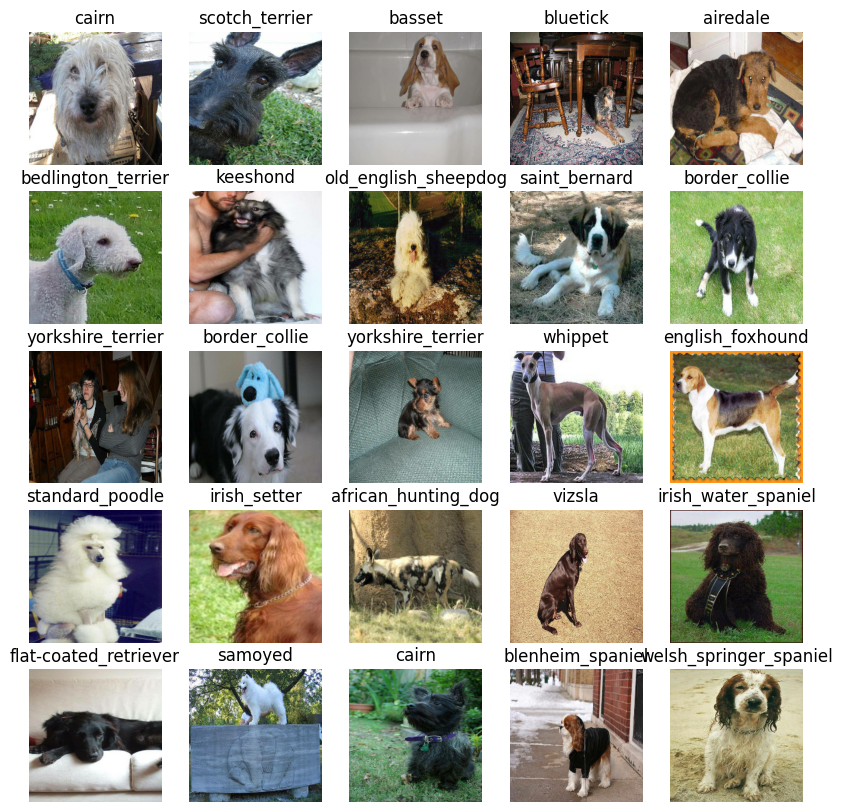

In [ ]:
# Visualize validation images from the validation data batch
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

## Building a model

Before we build a model, there are a few things we need to define:

* The input shape (images, in the form of Tensors) to our model.
* The output shape (image labels, in the form of Tensors) of our model.
* The URL of the model we want to use.

In [ ]:
#Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels

# Setup output shape of the model
OUTPUT_SHAPE = len(unique_breeds) # number of unique labels

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

Now, put everything together into a Keras deep learning model by creating a function that does the following:
* Takes the input shape, output shape, and the model we've chosen's URL as parameters.
* Defines the layers in a Keras model in a sequential fashion (do this first, then this, then that).
* Compiles the model (says how it should be evaluated and improved).
* Builds the model (tells it what kind of input shape it'll be getting).
* Returns the model.

In [ ]:
#Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
    tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                          activation="softmax") # Layer 2 (output layer)
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(), # Our model wants to reduce this (how wrong its guesses are)
      optimizer=tf.keras.optimizers.Adam(), # A friend telling our model how to improve its guesses
      metrics=["accuracy"] # We'd like this to go up
  )

  # Build the model
  model.build(INPUT_SHAPE) # Let the model know what kind of inputs it'll be getting

  return model

In [ ]:
# Create a model and check its details
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1001)              5432713   
                                                                 
 dense_1 (Dense)             (None, 120)               120240    
                                                                 
Total params: 5552953 (21.18 MB)
Trainable params: 120240 (469.69 KB)
Non-trainable params: 5432713 (20.72 MB)
_________________________________________________________________


Creating callbacks
* Tensorboard callback (visual way to monitor progress)
* Early Stopping callback (to prevent overfitting)

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("drive/MyDrive/Tech Education/Dog Data/logs",
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

In [ ]:
# Create early stopping (once our model stops improving, stop training)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3) # stops after 3 rounds of no improvements

## Training a model (on a subset of the data)
First model will be trained on 1000 images.

In [ ]:
# How many rounds should we get the model to look through the data?
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}

Function will be created to train a model. The function will:
* Create a model using create_model()
* Setup a TensorBoard callback using create_tensorboard_callback() (we do this here so it creates a log directory of the current date and time).
* Call the fit() function on our model passing it the training data, validatation data, number of epochs to train for and the callbacks we'd like to use.
* Return the fitted model.

In [ ]:
# Build a function to train and return a trained model
def train_model():
  """
  Trains a given model and returns the trained version.
  """
  # Create a model
  model = create_model()

  # Create new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1, # check validation metrics every epoch
            callbacks=[tensorboard, early_stopping])

  return model

In [ ]:
# Fit the model to the data
model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/100
25/25 [==============================] - 110s 4s/step - loss: 4.5065 - accuracy: 0.1050 - val_loss: 3.4697 - val_accuracy: 0.2600
Epoch 2/100
25/25 [==============================] - 3s 108ms/step - loss: 1.6060 - accuracy: 0.7050 - val_loss: 2.2217 - val_accuracy: 0.4800
Epoch 3/100
25/25 [==============================] - 4s 171ms/step - loss: 0.5613 - accuracy: 0.9312 - val_loss: 1.7549 - val_accuracy: 0.5850
Epoch 4/100
25/25 [==============================] - 3s 111ms/step - loss: 0.2507 - accuracy: 0.9887 - val_loss: 1.5980 - val_accuracy: 0.6100
Epoch 5/100
25/25 [==============================] - 3s 107ms/step - loss: 0.1459 - accuracy: 0.9950 - val_loss: 1.4986 - val_accuracy: 0.6250
Epoch 6/100
25/25 [==============================] - 3s 125ms/step - loss: 0.0985 - accuracy: 1.0000 - val_loss: 1.4522 - val_accuracy: 0.6350
Epoch 7/100
25/25 [==============================]

Now, the Tensorboard logs can be checked

In [ ]:
#%tensorboard --logdir drive/MyDrive/Tech\ Education/Dog\ Data/logs - Run Command to Check Logs
#!kill 68643 - Kill port if issues arise

## Making and evaluating predictions using a trained model

In [ ]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(val_data, verbose=1) # verbose shows us how long there is to go
predictions

7/7 [==============================] - 2s 103ms/step


array([[7.8039546e-04, 7.4287469e-05, 1.1544154e-03, ..., 1.0750591e-04,
        1.0837473e-05, 2.3851411e-03],
       [3.6013483e-03, 3.5351358e-04, 1.0294013e-02, ..., 2.7734570e-03,
        9.9691581e-03, 1.4713117e-04],
       [1.0269136e-04, 3.1955849e-05, 1.6183036e-04, ..., 2.6038610e-05,
        4.5117220e-05, 6.5995497e-04],
       ...,
       [2.0086974e-05, 3.6329304e-05, 4.1288928e-05, ..., 1.0185389e-05,
        8.8517736e-05, 3.2930321e-04],
       [1.1586146e-03, 3.9625829e-05, 5.8577865e-05, ..., 2.2312383e-04,
        3.5677378e-05, 1.0655383e-02],
       [2.8632767e-04, 7.2811657e-05, 6.6323509e-04, ..., 5.2710879e-03,
        6.9871271e-04, 7.5483535e-05]], dtype=float32)

Each value in the array corresponds to the probability of that label being the actual breed of the dog input image. However, these probabilities need to be converted to the actual label that the model predicted.

In [ ]:
# First prediction
print(predictions[0])
print(f"Max value (probability of prediction): {np.max(predictions[0])}") # the max probability value predicted by the model
print(f"Sum: {np.sum(predictions[0])}") # because we used softmax activation in our model, this will be close to 1
print(f"Max index: {np.argmax(predictions[0])}") # the index of where the max value in predictions[0] occurs
print(f"Predicted label: {unique_breeds[np.argmax(predictions[0])]}") # the predicted label

[7.80395465e-04 7.42874690e-05 1.15441543e-03 1.15985924e-03
 1.99789996e-04 3.89847155e-05 1.14490166e-02 4.43599420e-04
 3.40594677e-04 7.16865688e-05 3.12136748e-04 7.83047697e-04
 2.72523030e-04 1.18450138e-04 3.40351457e-04 2.55520572e-03
 1.09437842e-05 2.11657301e-01 9.32323292e-06 4.53930479e-05
 6.30796130e-04 2.40439040e-04 4.78836082e-05 4.00468532e-04
 3.07332557e-05 5.12452243e-05 1.07289813e-01 4.98016670e-05
 1.57958741e-04 5.28792676e-04 2.59478460e-04 7.78855348e-04
 1.77281690e-04 3.02344120e-06 2.87586503e-04 1.49259996e-02
 2.23500101e-05 2.00606679e-04 1.24276587e-04 7.65142104e-05
 7.74294720e-04 1.27681897e-05 1.10599045e-04 1.85954996e-04
 4.05774917e-05 2.14095169e-04 5.62747846e-05 7.96686509e-05
 5.16925356e-04 3.16709629e-05 3.04876332e-04 1.63236327e-05
 1.79294031e-04 9.69017856e-05 5.70354168e-05 2.50219437e-05
 5.38411514e-05 7.60051655e-04 1.20964462e-04 1.50093019e-01
 1.82702279e-04 9.28037025e-06 4.26588318e-04 2.49884852e-05
 1.71334847e-04 4.799267

It'd be great to have a way to see the image and the actual label vs. the predicted label. Functions can be created to do exactly this.

In [ ]:
# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[0])
pred_label

'soft-coated_wheaten_terrier'

Since our validation data (val_data) is in batch form, to get a list of validation images and labels, we'll have to unbatch it (using unbatch()) and then turn it into an iterator using as_numpy_iterator().

In [ ]:
# Create a function to unbatch a batched dataset
def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and returns separate arrays
  of images and labels.
  """
  images = []
  labels = []
  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images, labels

# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.27701408, 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

Now we've got ways to get:

* Prediction labels
* Validation labels (truth labels)
* Validation images

Let's make some functions to make these all a bit more visual.

In [ ]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth label and image for sample n.
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get the pred label
  pred_label = get_pred_label(pred_prob)

  # Plot image & remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the color of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  plt.title("{} {:2.0f}% ({})".format(pred_label,
                                      np.max(pred_prob)*100,
                                      true_label),
                                      color=color)

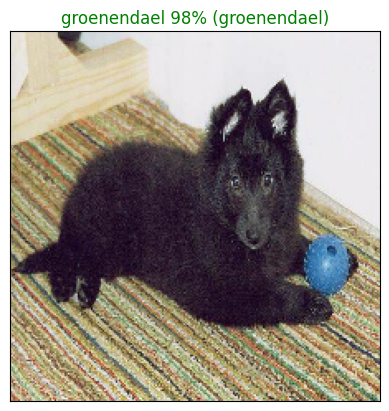

In [ ]:
#use-case example
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images,
          n=77)

Build a function that can:
* Take an input of a prediction probabilities array, a ground truth labels array and an integer.
* Find the predicted label using get_pred_label().
* Find the top 10:
  * Prediction probabilities indexes
  * Prediction probabilities values
  * Prediction labels
* Plot the top 10 prediction probability values and labels, coloring the true label green.

In [ ]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plots the top 10 highest prediction confidences along with
  the truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # Find the top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")

  # Change color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

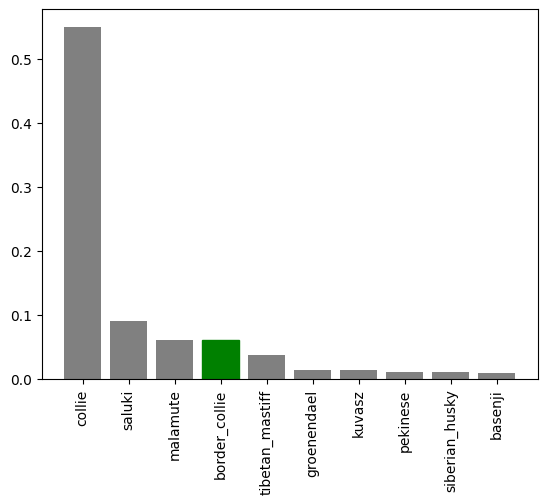

In [ ]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=9)

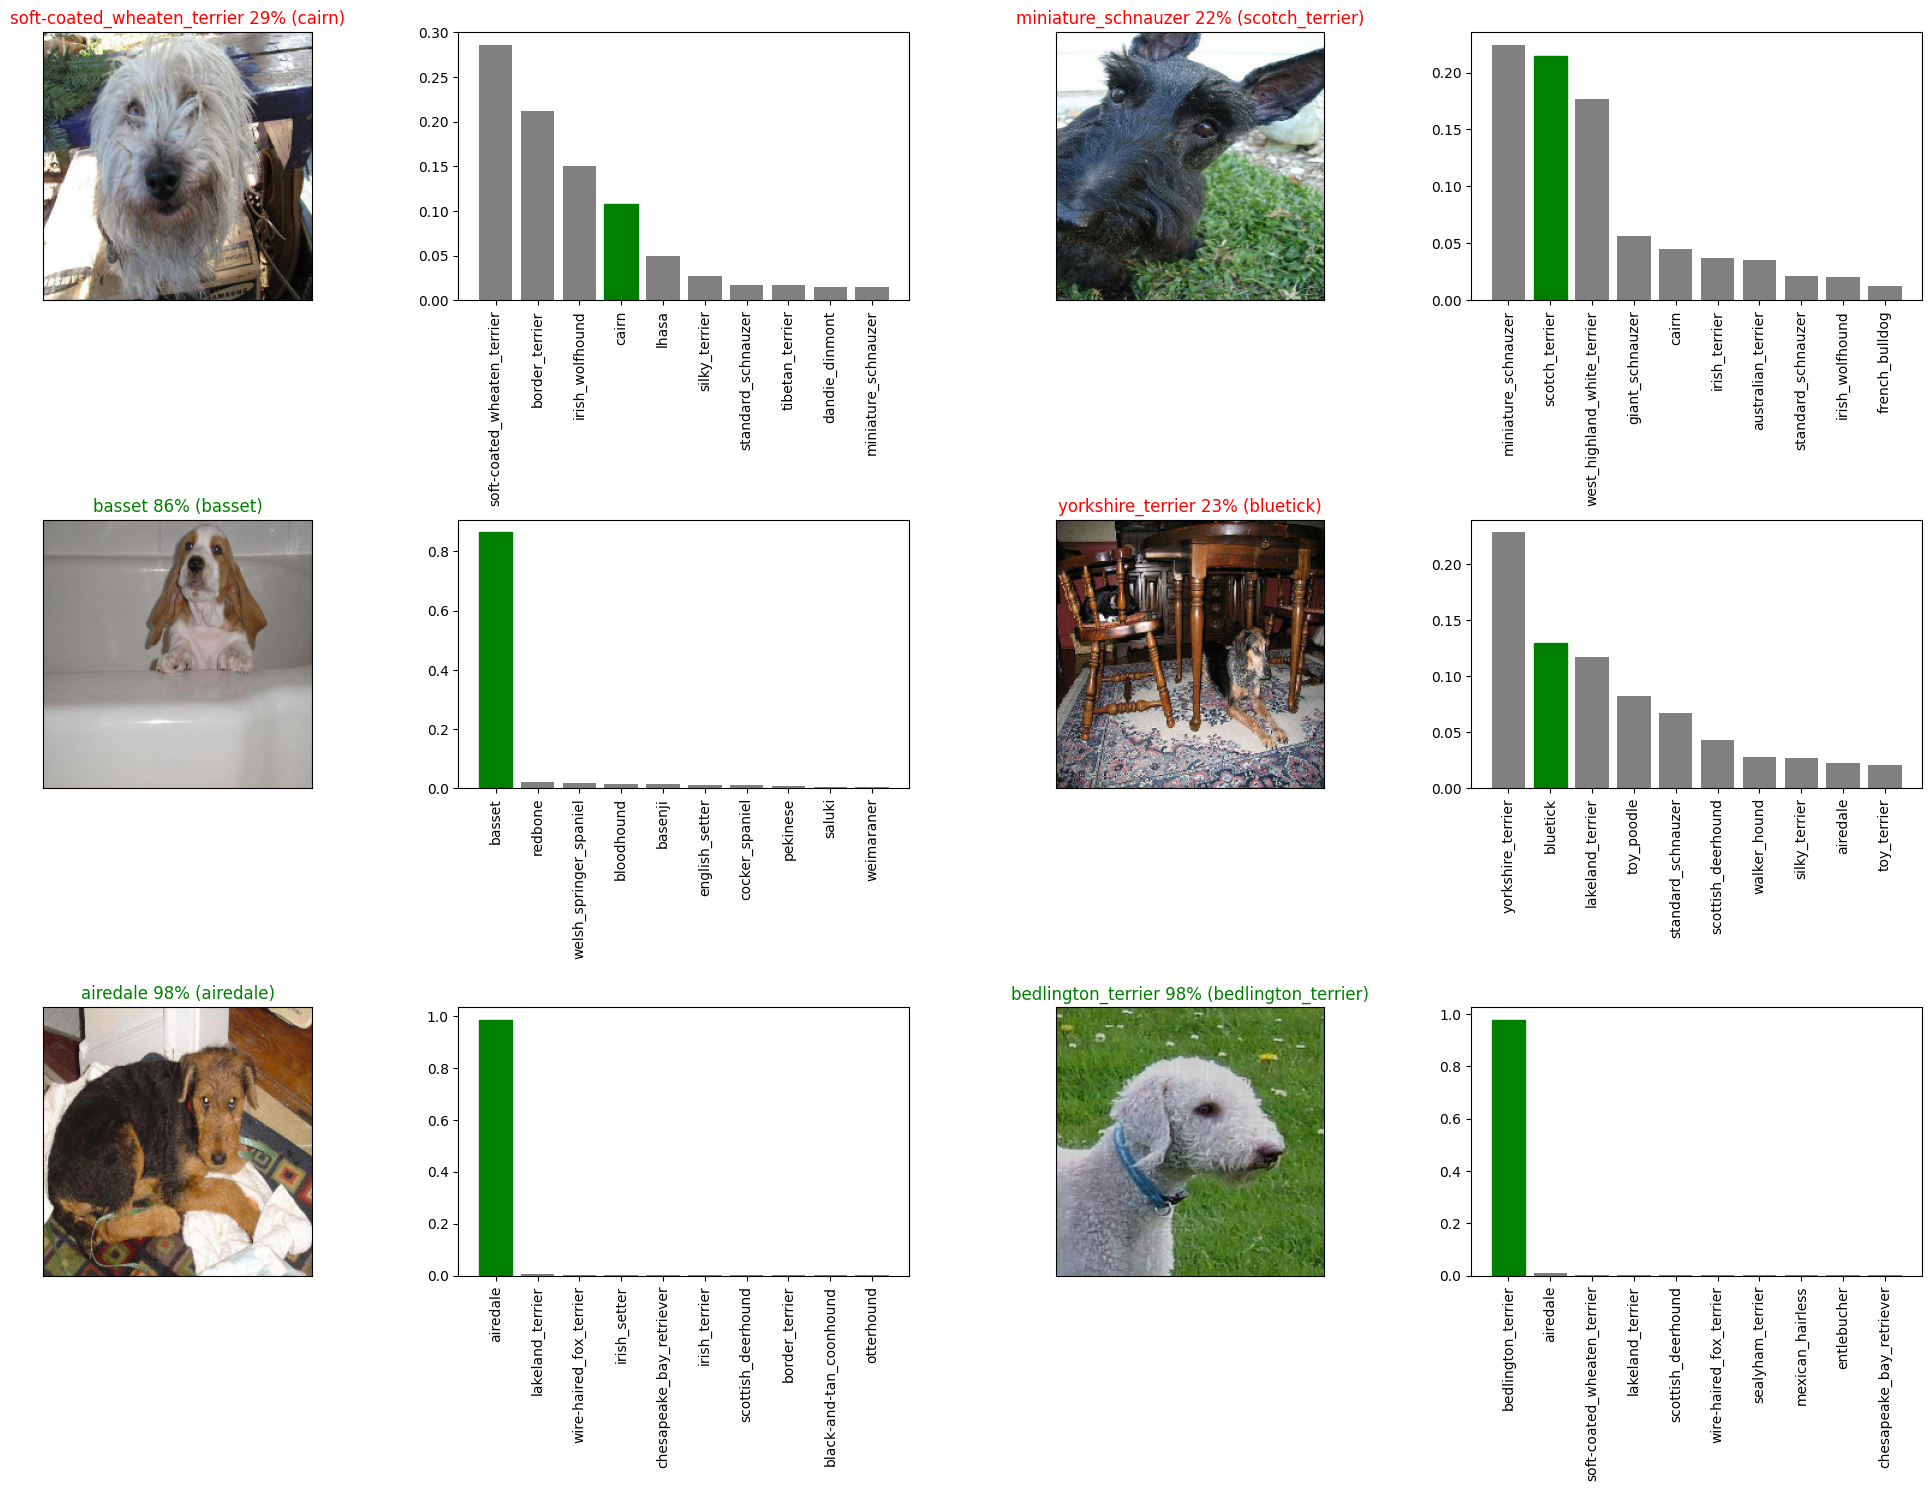

In [ ]:
# Let's check a few predictions and their different values
i_multiplier = 0
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                labels=val_labels,
                n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

## Saving and reloading the model

In [ ]:
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (str)
  for clarity and reuse.
  """
  # Create model directory with current time
  modeldir = os.path.join("drive/MyDrive/Tech Education/Dog Data/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [ ]:
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [ ]:
# Save our model trained on 1000 images
save_model(model, suffix="1000-images-Adam")

Saving model to: drive/MyDrive/Tech Education/Dog Data/models/20231012-22211697149285-1000-images-Adam.h5...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


'drive/MyDrive/Tech Education/Dog Data/models/20231012-22211697149285-1000-images-Adam.h5'

In [ ]:
# Load our model trained on 1000 images
model_1000_images = load_model("drive/MyDrive/Tech Education/Dog Data/models/20231012-22211697149285-1000-images-Adam.h5")

Loading saved model from: drive/MyDrive/Tech Education/Dog Data/models/20231012-22211697149285-1000-images-Adam.h5


In [ ]:
# Evaluate the pre-saved model
model.evaluate(val_data)

7/7 [==============================] - 1s 143ms/step - loss: 1.3255 - accuracy: 0.6650


[1.3254832029342651, 0.6650000214576721]

In [ ]:
# Evaluate the loaded model
model_1000_images.evaluate(val_data)

7/7 [==============================] - 2s 102ms/step - loss: 1.3255 - accuracy: 0.6650


[1.3254832029342651, 0.6650000214576721]

## Training a model (on the full data)
Now that we've trained our model on a subset of data, we can now train it on the full set of data available.

In [ ]:
# Remind ourselves of the size of the full dataset
len(X), len(y)

(10222, 10222)

In [ ]:
# Turn full training data in a data batch
full_data = create_data_batches(X, y)

Creating training data batches...


In [ ]:
# Instantiate a new model for training on the full dataset
full_model = create_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


In [ ]:
# Create full model callbacks

# TensorBoard callback
full_model_tensorboard = create_tensorboard_callback()

# Early stopping callback
# Note: No validation set when training on all the data, therefore can't monitor validation accruacy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=3)

In [ ]:
# Fit the full model to the full training data
full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_tensorboard,
                          full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 685s 2s/step - loss: 1.1522 - accuracy: 0.7048
Epoch 2/100
320/320 [==============================] - 27s 85ms/step - loss: 0.3948 - accuracy: 0.8837
Epoch 3/100
320/320 [==============================] - 27s 84ms/step - loss: 0.2318 - accuracy: 0.9369
Epoch 4/100
320/320 [==============================] - 27s 84ms/step - loss: 0.1545 - accuracy: 0.9628
Epoch 5/100
320/320 [==============================] - 28s 89ms/step - loss: 0.1056 - accuracy: 0.9779
Epoch 6/100
320/320 [==============================] - 28s 88ms/step - loss: 0.0778 - accuracy: 0.9867
Epoch 7/100
320/320 [==============================] - 28s 88ms/step - loss: 0.0578 - accuracy: 0.9922
Epoch 8/100
320/320 [==============================] - 30s 93ms/step - loss: 0.0465 - accuracy: 0.9943
Epoch 9/100
320/320 [==============================] - 30s 92ms/step - loss: 0.0376 - accuracy: 0.9965
Epoch 10/100
320/320 [==============================] - 28s 89ms/step - lo

## Saving and reloading the full model

In [ ]:
# Save model to file
save_model(full_model, suffix="all-images-Adam")

Saving model to: drive/MyDrive/Tech Education/Dog Data/models/20231012-23491697154569-all-images-Adam.h5...


'drive/MyDrive/Tech Education/Dog Data/models/20231012-23491697154569-all-images-Adam.h5'

In [ ]:
loaded_full_model = load_model("drive/MyDrive/Tech Education/Dog Data/models/20231012-23491697154569-all-images-Adam.h5")

Loading saved model from: drive/MyDrive/Tech Education/Dog Data/models/20231012-23491697154569-all-images-Adam.h5


## Making predictions on the test dataset
To do this:
* Get the test image filenames
* Convert the filenames into test data batches using create_data_batches() and setting the test_data parameter to True (since there are no labels with the test images).
* Make a predictions array by passing the test data batches to the predict() function.

In [ ]:
# Load test image filenames (since we're using os.listdir(), these already have .jpg)
test_path = "drive/MyDrive/Tech Education/Dog Data/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]

test_filenames[:10]

['drive/MyDrive/Tech Education/Dog Data/test/dd026c42cfd91ea64b1fe5db04a18863.jpg',
 'drive/MyDrive/Tech Education/Dog Data/test/e042a85a93edd51fe60ff5f9a9856902.jpg',
 'drive/MyDrive/Tech Education/Dog Data/test/e2b808864a5253fd356a9032915447a1.jpg',
 'drive/MyDrive/Tech Education/Dog Data/test/dd6ef59cad61882fec54f4b6a429065e.jpg',
 'drive/MyDrive/Tech Education/Dog Data/test/e7dc8cc599049ea9fa2a172c88646c57.jpg',
 'drive/MyDrive/Tech Education/Dog Data/test/e4c49d7e028965d3504b0862633464c3.jpg',
 'drive/MyDrive/Tech Education/Dog Data/test/e7f95aabf775a636b3893ffa120adaf9.jpg',
 'drive/MyDrive/Tech Education/Dog Data/test/e3b9e9c903bbcf09fc0da06efabaec1c.jpg',
 'drive/MyDrive/Tech Education/Dog Data/test/e78b4a09e5f86c330e24c6aaed63f0be.jpg',
 'drive/MyDrive/Tech Education/Dog Data/test/e443bb594a89ab5fa1266748d6b41648.jpg']

In [ ]:
# How many test images are there?
len(test_filenames)

10357

In [ ]:
# Create test data batch
test_data = create_data_batches(test_filenames, test_data=True)

Creating test data batches...


In [ ]:
# Make predictions on test data batch using the loaded full model
test_predictions = loaded_full_model.predict(test_data,
                                             verbose=1)

In [ ]:
#Save predictions
np.savetxt("drive/MyDrive/Tech Education/Dog Data/preds_array.csv", test_predictions, delimiter = ",")

In [ ]:
#Load saved predictions
test_predictions = np.loadtxt("drive/MyDrive/Tech Education/Dog Data/preds_array.csv", delimiter = ",")

## Preparing test dataset predictions for Kaggle
To do this:
* Create a pandas DataFrame with an ID column as well as a column for each dog breed.
* Add data to the ID column by extracting the test image ID's from their filepaths.
* Add data (the prediction probabilities) to each of the dog breed columns using the unique_breeds list and the test_predictions list.
* Export the DataFrame as a CSV to submit it to Kaggle.

In [ ]:
# Create pandas DataFrame with empty columns
preds_df = pd.DataFrame(columns=["id"] + list(unique_breeds))
preds_df.head()

In [ ]:
# Append test image ID's to predictions DataFrame
test_path = "drive/MyDrive/Tech Education/Dog Data/test"
preds_df["id"] = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df.head()

In [ ]:
# Add the prediction probabilities to each dog breed column
preds_df[list(unique_breeds)] = test_predictions
preds_df.head()

In [ ]:
preds_df.to_csv("drive/MyDrive/Tech Education/Dog Data/full_submission_1_mobilienetV2_adam.csv",
                 index=False)

## Making predictions on custom images
* Get the filepaths of our own images.
* Turn the filepaths into data batches using create_data_batches(). And since our custom images won't have labels, we set the test_data parameter to True.
* Pass the custom image data batch to our model's predict() method.
* Convert the prediction output probabilities to prediction labels.
* Compare the predicted labels to the custom images.

In [ ]:
# Get custom image filepaths
custom_path = "drive/My Drive/Data/dogs/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]

In [ ]:
# Turn custom image into batch (set to test data because there are no labels)
custom_data = create_data_batches(custom_image_paths, test_data=True)

In [ ]:
# Make predictions on the custom data
custom_preds = loaded_full_model.predict(custom_data)

In [ ]:
# Get custom image prediction labels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

In [ ]:
# Get custom images (our unbatchify() function won't work since there aren't labels)
custom_images = []
# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

In [ ]:
# Check custom image predictions
plt.figure(figsize=(10, 10))
for i, image in enumerate(custom_images):
  plt.subplot(1, 3, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)